# Tiny Recursive Model (TRM) for Decoder-Only LLM & VLM

This notebook implements the TRM (Tiny Recursive Model) concept from the paper "Less is More: Recursive Reasoning with Tiny Networks" adapted for:

1. **Part 1**: A decoder-only language model using recursive reasoning
2. **Part 2**: Evaluation on text generation tasks
3. **Part 3**: Extension to Vision-Language Model (VLM) with contrastive alignment

## Key TRM Concepts:
- **Recursive Reasoning**: Instead of a deep network, use a tiny network that recurses multiple times
- **Three State Variables**: Input `x`, current answer `y`, and latent reasoning state `z`
- **Deep Supervision**: Apply loss at each recursion step
- **Single Network**: Use one small network instead of multiple large ones

## Architecture Overview:
```
For each recursion step:
    z = net(x, y, z) + z  # Update reasoning state with residual
    y = update_answer(z)   # Refine answer based on reasoning
```

## Setup and Imports

In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
# Install required packages
# ! uv pip install torch torchvision torchaudio --quiet
# ! uv pip install transformers datasets tiktoken einops --quiet
# ! uv pip install matplotlib seaborn tqdm --quiet

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import math
from dataclasses import dataclass
from typing import Optional, Tuple, List, Dict
import random

# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


---
# Part 1: TRM Decoder-Only Language Model

We implement a decoder-only transformer that uses TRM's recursive reasoning approach.

## Key Adaptations for Causal LM:
1. **Causal Attention**: Use masked attention for autoregressive generation
2. **Recursive Refinement**: Apply TRM recursion to refine hidden states
3. **Deep Supervision**: Compute loss at each recursion for better training signal

## 1.1 Core Building Blocks

In [18]:
@dataclass
class TRMDecoderConfig:
    """Configuration for TRM Decoder LLM"""
    vocab_size: int = 32000
    hidden_size: int = 256
    num_heads: int = 4
    num_layers: int = 2  # TRM uses tiny networks (2 layers as per paper)
    max_seq_len: int = 512
    dropout: float = 0.1
    
    # TRM specific
    n_recursions: int = 6  # Number of latent reasoning steps (n in paper)
    t_cycles: int = 3  # Number of deep supervision cycles (T in paper)
    
    # Expansion factor for MLP
    expansion: float = 2.67  # SwiGLU expansion
    
    # Normalization
    rms_norm_eps: float = 1e-5
    rope_theta: float = 10000.0
    
    def __post_init__(self):
        self.head_dim = self.hidden_size // self.num_heads
        self.intermediate_size = int(self.hidden_size * self.expansion)

In [19]:
class RMSNorm(nn.Module):
    """Root Mean Square Layer Normalization"""
    def __init__(self, dim: int, eps: float = 1e-5):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(dim))
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        rms = torch.sqrt(torch.mean(x ** 2, dim=-1, keepdim=True) + self.eps)
        return x / rms * self.weight


def rms_norm(x: torch.Tensor, eps: float = 1e-5) -> torch.Tensor:
    """Functional RMS normalization without learnable params"""
    rms = torch.sqrt(torch.mean(x ** 2, dim=-1, keepdim=True) + eps)
    return x / rms

In [20]:
class RotaryEmbedding(nn.Module):
    """Rotary Position Embedding (RoPE)"""
    def __init__(self, dim: int, max_seq_len: int = 2048, base: float = 10000.0):
        super().__init__()
        self.dim = dim
        self.max_seq_len = max_seq_len
        self.base = base
        
        # Precompute inverse frequencies
        inv_freq = 1.0 / (base ** (torch.arange(0, dim, 2).float() / dim))
        self.register_buffer('inv_freq', inv_freq)
        
        # Precompute cos and sin
        self._build_cache(max_seq_len)
    
    def _build_cache(self, seq_len: int):
        t = torch.arange(seq_len, device=self.inv_freq.device)
        freqs = torch.einsum('i,j->ij', t, self.inv_freq)
        emb = torch.cat([freqs, freqs], dim=-1)
        self.register_buffer('cos_cached', emb.cos())
        self.register_buffer('sin_cached', emb.sin())
    
    def forward(self, seq_len: int) -> Tuple[torch.Tensor, torch.Tensor]:
        if seq_len > self.max_seq_len:
            self._build_cache(seq_len)
        return self.cos_cached[:seq_len], self.sin_cached[:seq_len]


def rotate_half(x: torch.Tensor) -> torch.Tensor:
    """Rotate half the hidden dims of the input."""
    x1, x2 = x.chunk(2, dim=-1)
    return torch.cat([-x2, x1], dim=-1)


def apply_rotary_pos_emb(q: torch.Tensor, k: torch.Tensor, 
                         cos: torch.Tensor, sin: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
    """Apply rotary embeddings to queries and keys."""
    # Reshape for broadcasting: (seq_len, dim) -> (1, 1, seq_len, dim)
    cos = cos.unsqueeze(0).unsqueeze(1)  # (1, 1, seq_len, dim)
    sin = sin.unsqueeze(0).unsqueeze(1)
    
    q_embed = (q * cos) + (rotate_half(q) * sin)
    k_embed = (k * cos) + (rotate_half(k) * sin)
    return q_embed, k_embed

In [21]:
class SwiGLU(nn.Module):
    """SwiGLU activation function with linear projections"""
    def __init__(self, hidden_size: int, intermediate_size: int):
        super().__init__()
        self.gate_proj = nn.Linear(hidden_size, intermediate_size, bias=False)
        self.up_proj = nn.Linear(hidden_size, intermediate_size, bias=False)
        self.down_proj = nn.Linear(intermediate_size, hidden_size, bias=False)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.down_proj(F.silu(self.gate_proj(x)) * self.up_proj(x))

In [22]:
class CausalSelfAttention(nn.Module):
    """Multi-head causal self-attention with RoPE"""
    def __init__(self, config: TRMDecoderConfig):
        super().__init__()
        self.config = config
        self.hidden_size = config.hidden_size
        self.num_heads = config.num_heads
        self.head_dim = config.head_dim
        
        # QKV projection
        self.q_proj = nn.Linear(config.hidden_size, config.hidden_size, bias=False)
        self.k_proj = nn.Linear(config.hidden_size, config.hidden_size, bias=False)
        self.v_proj = nn.Linear(config.hidden_size, config.hidden_size, bias=False)
        self.o_proj = nn.Linear(config.hidden_size, config.hidden_size, bias=False)
        
        self.dropout = nn.Dropout(config.dropout)
        
    def forward(self, hidden_states: torch.Tensor, 
                cos: torch.Tensor, sin: torch.Tensor,
                attention_mask: Optional[torch.Tensor] = None) -> torch.Tensor:
        B, L, _ = hidden_states.shape
        
        # Project to Q, K, V
        q = self.q_proj(hidden_states).view(B, L, self.num_heads, self.head_dim).transpose(1, 2)
        k = self.k_proj(hidden_states).view(B, L, self.num_heads, self.head_dim).transpose(1, 2)
        v = self.v_proj(hidden_states).view(B, L, self.num_heads, self.head_dim).transpose(1, 2)
        
        # Apply RoPE
        q, k = apply_rotary_pos_emb(q, k, cos, sin)
        
        # Attention scores
        scale = 1.0 / math.sqrt(self.head_dim)
        attn_weights = torch.matmul(q, k.transpose(-2, -1)) * scale
        
        # Causal mask
        if attention_mask is None:
            causal_mask = torch.triu(torch.ones(L, L, device=hidden_states.device), diagonal=1).bool()
            attn_weights = attn_weights.masked_fill(causal_mask.unsqueeze(0).unsqueeze(0), float('-inf'))
        else:
            attn_weights = attn_weights + attention_mask
        
        attn_weights = F.softmax(attn_weights, dim=-1)
        attn_weights = self.dropout(attn_weights)
        
        # Apply attention to values
        attn_output = torch.matmul(attn_weights, v)
        attn_output = attn_output.transpose(1, 2).contiguous().view(B, L, self.hidden_size)
        
        return self.o_proj(attn_output)

## 1.2 TRM Transformer Block

In [23]:
class TRMBlock(nn.Module):
    """
    A single TRM transformer block.
    Uses Post-Norm architecture as per the TRM paper.
    """
    def __init__(self, config: TRMDecoderConfig):
        super().__init__()
        self.config = config
        
        # Self-attention
        self.self_attn = CausalSelfAttention(config)
        
        # Feed-forward (SwiGLU)
        self.mlp = SwiGLU(config.hidden_size, config.intermediate_size)
        
        # Post-norm (as per TRM paper)
        self.attn_norm = RMSNorm(config.hidden_size, config.rms_norm_eps)
        self.mlp_norm = RMSNorm(config.hidden_size, config.rms_norm_eps)
    
    def forward(self, hidden_states: torch.Tensor,
                cos: torch.Tensor, sin: torch.Tensor,
                attention_mask: Optional[torch.Tensor] = None) -> torch.Tensor:
        # Self-attention with post-norm
        residual = hidden_states
        hidden_states = self.self_attn(hidden_states, cos, sin, attention_mask)
        hidden_states = self.attn_norm(residual + hidden_states)
        
        # MLP with post-norm
        residual = hidden_states
        hidden_states = self.mlp(hidden_states)
        hidden_states = self.mlp_norm(residual + hidden_states)
        
        return hidden_states

## 1.3 TRM Reasoning Module

In [24]:
class TRMReasoningModule(nn.Module):
    """
    The core TRM reasoning module that applies recursive reasoning.
    This module takes (x, y, z) and updates z through multiple transformer blocks,
    then updates y based on the refined z.
    """
    def __init__(self, config: TRMDecoderConfig):
        super().__init__()
        self.config = config
        
        # The tiny network (2 layers as per TRM paper)
        self.layers = nn.ModuleList([TRMBlock(config) for _ in range(config.num_layers)])
    
    def forward(self, hidden_states: torch.Tensor, 
                input_injection: torch.Tensor,
                cos: torch.Tensor, sin: torch.Tensor,
                attention_mask: Optional[torch.Tensor] = None) -> torch.Tensor:
        """
        Args:
            hidden_states: Current latent state z (B, L, D)
            input_injection: Combined input x + y embedding (B, L, D)
            cos, sin: Rotary position embeddings
            attention_mask: Optional attention mask
        
        Returns:
            Updated hidden states
        """
        # Input injection (add)
        hidden_states = hidden_states + input_injection
        
        # Pass through transformer layers
        for layer in self.layers:
            hidden_states = layer(hidden_states, cos, sin, attention_mask)
        
        return hidden_states

## 1.4 Complete TRM Decoder LLM

In [25]:
class TRMDecoderLLM(nn.Module):
    """
    TRM-based Decoder-Only Language Model.
    
    Key Features:
    1. Recursive reasoning with a tiny network
    2. Deep supervision at each recursion step
    3. Single network for both z and y updates
    """
    def __init__(self, config: TRMDecoderConfig):
        super().__init__()
        self.config = config
        
        # Token embeddings
        self.embed_scale = math.sqrt(config.hidden_size)
        self.token_embedding = nn.Embedding(config.vocab_size, config.hidden_size)
        
        # Rotary embeddings
        self.rotary_emb = RotaryEmbedding(
            dim=config.head_dim,
            max_seq_len=config.max_seq_len,
            base=config.rope_theta
        )
        
        # TRM Reasoning Module (shared across recursions)
        self.reasoning = TRMReasoningModule(config)
        
        # Output projection (LM head)
        self.lm_head = nn.Linear(config.hidden_size, config.vocab_size, bias=False)
        
        # Initial state for z (learnable)
        self.z_init = nn.Parameter(torch.randn(config.hidden_size) * 0.02)
        
        # Dropout
        self.dropout = nn.Dropout(config.dropout)
        
        # Initialize weights
        self._init_weights()
    
    def _init_weights(self):
        """Initialize weights with truncated normal distribution"""
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.trunc_normal_(module.weight, std=0.02)
                if module.bias is not None:
                    nn.init.zeros_(module.bias)
            elif isinstance(module, nn.Embedding):
                nn.init.trunc_normal_(module.weight, std=0.02)
    
    def get_input_embeddings(self, input_ids: torch.Tensor) -> torch.Tensor:
        """Get token embeddings scaled by sqrt(hidden_size)"""
        return self.embed_scale * self.token_embedding(input_ids)
    
    def forward(self, 
                input_ids: torch.Tensor,
                labels: Optional[torch.Tensor] = None,
                attention_mask: Optional[torch.Tensor] = None,
                return_all_logits: bool = False) -> Dict[str, torch.Tensor]:
        """
        Forward pass with TRM recursive reasoning.
        
        Args:
            input_ids: Token IDs (B, L)
            labels: Target labels for language modeling loss (B, L)
            attention_mask: Optional attention mask
            return_all_logits: If True, return logits from all recursion steps
        
        Returns:
            Dictionary with 'logits', 'loss' (if labels provided), 
            and 'all_logits' (if return_all_logits=True)
        """
        B, L = input_ids.shape
        device = input_ids.device
        
        # Get input embeddings (this is 'x' in TRM)
        x_emb = self.get_input_embeddings(input_ids)  # (B, L, D)
        x_emb = self.dropout(x_emb)
        
        # Get rotary embeddings
        cos, sin = self.rotary_emb(L)
        
        # Initialize y (answer draft) as copy of x
        y_emb = x_emb.clone()
        
        # Initialize z (reasoning state)
        z = self.z_init.unsqueeze(0).unsqueeze(0).expand(B, L, -1)
        
        all_logits = []
        
        # TRM Recursive Reasoning Loop
        # T cycles, each with n recursions
        for t in range(self.config.t_cycles):
            # Determine if we should track gradients
            # Only the last cycle gets gradients (as per TRM paper)
            use_grad = (t == self.config.t_cycles - 1)
            
            with torch.set_grad_enabled(use_grad or self.training):
                # n recursions to update z
                for n in range(self.config.n_recursions):
                    # Update z given (x + y) and current z
                    input_injection = x_emb + y_emb
                    z = self.reasoning(z, input_injection, cos, sin, attention_mask)
                
                # Update y given z (one more pass through reasoning module)
                z_for_y = self.reasoning(z, torch.zeros_like(z), cos, sin, attention_mask)
                
                # Compute logits for this cycle
                logits = self.lm_head(z_for_y)
                all_logits.append(logits)
                
                # Soft update of y_emb using logits
                probs = F.softmax(logits, dim=-1)  # (B, L, V)
                # Compute weighted embedding
                y_emb = probs @ self.token_embedding.weight  # (B, L, D)
                y_emb = self.embed_scale * y_emb
            
            # Detach z for next cycle (as per TRM paper)
            z = z.detach()
            y_emb = y_emb.detach()
        
        # Final logits are from the last cycle
        final_logits = all_logits[-1]
        
        outputs = {'logits': final_logits}
        
        if return_all_logits:
            outputs['all_logits'] = all_logits
        
        # Compute loss with deep supervision
        if labels is not None:
            # Shift for causal LM
            shift_logits = final_logits[:, :-1, :].contiguous()
            shift_labels = labels[:, 1:].contiguous()
            
            # Deep supervision loss (average over all cycles)
            total_loss = 0.0
            for cycle_logits in all_logits:
                cycle_shift_logits = cycle_logits[:, :-1, :].contiguous()
                loss = F.cross_entropy(
                    cycle_shift_logits.view(-1, self.config.vocab_size),
                    shift_labels.view(-1),
                    ignore_index=-100
                )
                total_loss += loss
            
            outputs['loss'] = total_loss / len(all_logits)
        
        return outputs
    
    @torch.no_grad()
    def generate(self, 
                 input_ids: torch.Tensor,
                 max_new_tokens: int = 50,
                 temperature: float = 1.0,
                 top_k: Optional[int] = None,
                 top_p: Optional[float] = None) -> torch.Tensor:
        """
        Generate text autoregressively.
        """
        self.eval()
        
        for _ in range(max_new_tokens):
            # Crop input to max_seq_len if needed
            idx_cond = input_ids[:, -self.config.max_seq_len:]
            
            # Forward pass
            outputs = self(idx_cond)
            logits = outputs['logits'][:, -1, :] / temperature
            
            # Apply top-k filtering
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = float('-inf')
            
            # Apply top-p (nucleus) filtering
            if top_p is not None:
                sorted_logits, sorted_indices = torch.sort(logits, descending=True)
                cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)
                sorted_indices_to_remove = cumulative_probs > top_p
                sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
                sorted_indices_to_remove[..., 0] = 0
                indices_to_remove = sorted_indices_to_remove.scatter(1, sorted_indices, sorted_indices_to_remove)
                logits[indices_to_remove] = float('-inf')
            
            # Sample
            probs = F.softmax(logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)
            
            # Append
            input_ids = torch.cat([input_ids, next_token], dim=-1)
        
        return input_ids

## 1.5 Model Summary and Parameter Count

In [26]:
def count_parameters(model: nn.Module) -> int:
    """Count trainable parameters in a model"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def print_model_summary(config: TRMDecoderConfig):
    """Print model configuration summary"""
    model = TRMDecoderLLM(config)
    
    print("=" * 60)
    print("TRM Decoder LLM Configuration")
    print("=" * 60)
    print(f"Vocabulary Size: {config.vocab_size:,}")
    print(f"Hidden Size: {config.hidden_size}")
    print(f"Number of Heads: {config.num_heads}")
    print(f"Number of Layers: {config.num_layers}")
    print(f"Max Sequence Length: {config.max_seq_len}")
    print(f"\nTRM Parameters:")
    print(f"  - N Recursions (n): {config.n_recursions}")
    print(f"  - T Cycles (T): {config.t_cycles}")
    print(f"  - Effective Depth: {config.num_layers * (config.n_recursions + 1) * config.t_cycles}")
    print(f"\nTotal Parameters: {count_parameters(model):,}")
    print(f"  (~{count_parameters(model) / 1e6:.2f}M)")
    print("=" * 60)
    
    return model

# Create a small config for testing
test_config = TRMDecoderConfig(
    vocab_size=1000,
    hidden_size=256,
    num_heads=4,
    num_layers=2,
    max_seq_len=128,
    n_recursions=4,
    t_cycles=3
)

model = print_model_summary(test_config)

TRM Decoder LLM Configuration
Vocabulary Size: 1,000
Hidden Size: 256
Number of Heads: 4
Number of Layers: 2
Max Sequence Length: 128

TRM Parameters:
  - N Recursions (n): 4
  - T Cycles (T): 3
  - Effective Depth: 30

Total Parameters: 2,086,656
  (~2.09M)


In [27]:
# Test forward pass
model = model.to(device)

# Create dummy input
batch_size = 4
seq_len = 32
dummy_input = torch.randint(0, test_config.vocab_size, (batch_size, seq_len)).to(device)
dummy_labels = dummy_input.clone()

# Forward pass
outputs = model(dummy_input, labels=dummy_labels, return_all_logits=True)

print(f"Input shape: {dummy_input.shape}")
print(f"Output logits shape: {outputs['logits'].shape}")
print(f"Loss: {outputs['loss'].item():.4f}")
print(f"Number of intermediate logits: {len(outputs['all_logits'])}")

Input shape: torch.Size([4, 32])
Output logits shape: torch.Size([4, 32, 1000])
Loss: 6.9383
Number of intermediate logits: 3


---
# Part 2: Training and Evaluation

We'll train our TRM LLM on a simple character-level task and evaluate its performance.

## 2.1 Character-Level Dataset

In [28]:
class CharDataset(Dataset):
    """Character-level dataset for training"""
    def __init__(self, text: str, seq_len: int = 64):
        self.seq_len = seq_len
        
        # Build vocabulary
        chars = sorted(list(set(text)))
        self.vocab_size = len(chars)
        self.char_to_idx = {ch: i for i, ch in enumerate(chars)}
        self.idx_to_char = {i: ch for i, ch in enumerate(chars)}
        
        # Encode text
        self.data = torch.tensor([self.char_to_idx[ch] for ch in text], dtype=torch.long)
        
    def __len__(self):
        return len(self.data) - self.seq_len
    
    def __getitem__(self, idx):
        x = self.data[idx:idx + self.seq_len]
        y = self.data[idx + 1:idx + self.seq_len + 1]
        return x, y
    
    def decode(self, indices):
        """Decode indices to text"""
        return ''.join([self.idx_to_char[i.item()] for i in indices])

In [29]:
# Create a simple training corpus
# Using a simple repeating pattern dataset to test learning
sample_text = """
The quick brown fox jumps over the lazy dog. 
A quick brown fox jumps over a lazy dog. 
One quick brown fox jumps over one lazy dog.
Two quick brown foxes jump over two lazy dogs.
The lazy dog sleeps while the quick fox runs.
Quick foxes are smarter than lazy dogs.
Dogs chase foxes and foxes run from dogs.
In the forest, foxes hunt and dogs guard.
The brown fox is quick and the gray dog is lazy.
Every morning, the fox runs and the dog sleeps.
""" * 100  # Repeat to create more data

# Create dataset
seq_len = 64
dataset = CharDataset(sample_text, seq_len=seq_len)

print(f"Dataset size: {len(dataset)}")
print(f"Vocabulary size: {dataset.vocab_size}")
print(f"Vocabulary: {list(dataset.char_to_idx.keys())}")

Dataset size: 44736
Vocabulary size: 37
Vocabulary: ['\n', ' ', ',', '.', 'A', 'D', 'E', 'I', 'O', 'Q', 'T', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


## 2.2 Training Loop

In [30]:
def train_trm_llm(model, dataset, config, num_epochs=10, batch_size=32, lr=1e-3, device='cuda'):
    """
    Training loop for TRM LLM with deep supervision.
    """
    model = model.to(device)
    model.train()
    
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=0.1)
    
    # Learning rate scheduler with warmup
    total_steps = len(dataloader) * num_epochs
    warmup_steps = total_steps // 10
    
    def lr_lambda(step):
        if step < warmup_steps:
            return step / warmup_steps
        else:
            return 0.5 * (1 + math.cos(math.pi * (step - warmup_steps) / (total_steps - warmup_steps)))
    
    scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
    
    loss_history = []
    
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")
        
        for batch_idx, (x, y) in enumerate(pbar):
            x, y = x.to(device), y.to(device)
            
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(x, labels=y)
            loss = outputs['loss']
            
            # Backward pass
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            
            epoch_loss += loss.item()
            loss_history.append(loss.item())
            
            pbar.set_postfix({'loss': f'{loss.item():.4f}', 'lr': f'{scheduler.get_last_lr()[0]:.2e}'})
        
        avg_loss = epoch_loss / len(dataloader)
        print(f"Epoch {epoch+1}/{num_epochs} - Average Loss: {avg_loss:.4f}")
    
    return loss_history

In [31]:
# Create model with appropriate vocab size
train_config = TRMDecoderConfig(
    vocab_size=dataset.vocab_size,
    hidden_size=128,
    num_heads=4,
    num_layers=2,
    max_seq_len=seq_len,
    n_recursions=4,
    t_cycles=3,
    dropout=0.1
)

trm_model = TRMDecoderLLM(train_config)
print(f"Model parameters: {count_parameters(trm_model):,}")

# Train the model
loss_history = train_trm_llm(
    trm_model, 
    dataset, 
    train_config,
    num_epochs=5,
    batch_size=32,
    lr=3e-4,
    device=device
)

Model parameters: 403,072


Epoch 1/5:   0%|          | 0/1398 [00:00<?, ?it/s]

Epoch 1/5 - Average Loss: 0.7459


Epoch 2/5:   0%|          | 0/1398 [00:00<?, ?it/s]

Epoch 2/5 - Average Loss: 0.0780


Epoch 3/5:   0%|          | 0/1398 [00:00<?, ?it/s]

Epoch 3/5 - Average Loss: 0.0719


Epoch 4/5:   0%|          | 0/1398 [00:00<?, ?it/s]

Epoch 4/5 - Average Loss: 0.0693


Epoch 5/5:   0%|          | 0/1398 [00:00<?, ?it/s]

Epoch 5/5 - Average Loss: 0.0680


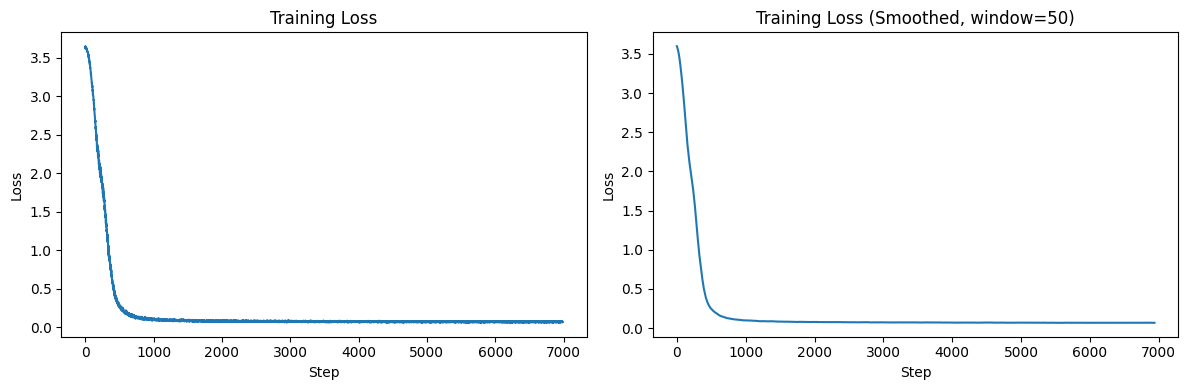

In [32]:
# Plot training loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(loss_history)
plt.title('Training Loss')
plt.xlabel('Step')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
# Moving average
window = 50
smoothed = np.convolve(loss_history, np.ones(window)/window, mode='valid')
plt.plot(smoothed)
plt.title(f'Training Loss (Smoothed, window={window})')
plt.xlabel('Step')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()

## 2.3 Text Generation

In [33]:
def generate_text(model, dataset, prompt, max_new_tokens=100, temperature=0.8):
    """
    Generate text from a prompt.
    """
    model.eval()
    
    # Encode prompt
    input_ids = torch.tensor([[dataset.char_to_idx.get(ch, 0) for ch in prompt]], device=device)
    
    # Generate
    output_ids = model.generate(
        input_ids,
        max_new_tokens=max_new_tokens,
        temperature=temperature,
        top_k=40
    )
    
    # Decode
    generated_text = dataset.decode(output_ids[0])
    return generated_text

# Generate some text samples
prompts = [
    "The quick brown ",
    "A lazy dog ",
    "Foxes are "
]

print("=" * 60)
print("Text Generation Examples")
print("=" * 60)

for prompt in prompts:
    generated = generate_text(trm_model, dataset, prompt, max_new_tokens=80, temperature=0.7)
    print(f"\nPrompt: '{prompt}'")
    print(f"Generated: {generated}")
    print("-" * 40)

Text Generation Examples

Prompt: 'The quick brown '
Generated: The quick brown o rn alz wigjmdteymsonn,te oefxshnfxsadt oedtrtrt onn,tonfxshnfxo utadt oedt oed
----------------------------------------

Prompt: 'A lazy dog '
Generated: A lazy dog lep hlep.
vrteym oel h aydgsw hlep hlep vrymdteymdgig h alep hlep vrteyd
vrymsoe
----------------------------------------

Prompt: 'Foxes are '
Generated: 
oxes are mrihnta adg lz.
vro reym oe o o oes alesslesqikh uc oesw hlesw oeqikfxrnn.Qikfxj
----------------------------------------


## 2.4 Analyzing Recursive Refinement

Input: 'The quick brown fo'

Predictions at position -1 (next char after input):
------------------------------------------------------------

Cycle 1:
  ' ': 0.9996
  e: 0.0002
  o: 0.0000
  .: 0.0000
  s: 0.0000

Cycle 2:
  ' ': 0.9998
  e: 0.0000
  o: 0.0000
  r: 0.0000
  s: 0.0000

Cycle 3:
  ' ': 0.9998
  e: 0.0000
  r: 0.0000
  s: 0.0000
  o: 0.0000


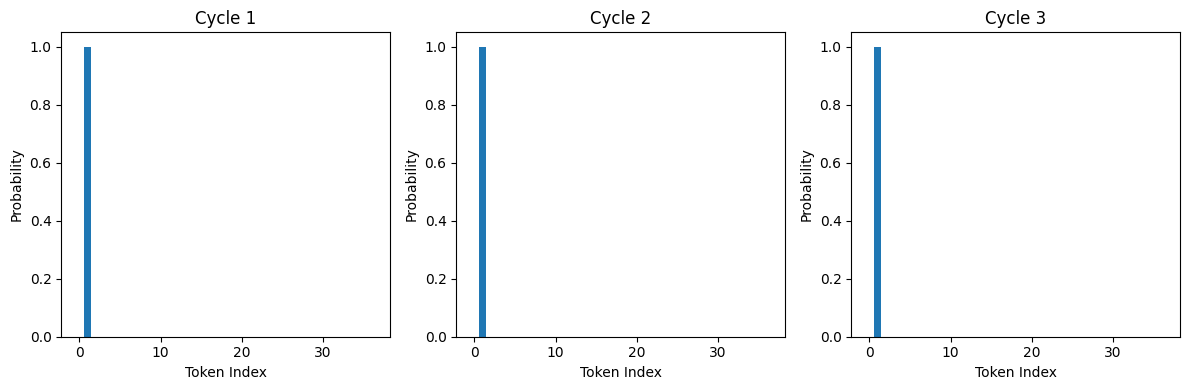

In [42]:
def analyze_recursion_steps(model, dataset, text, device='cuda'):
    """
    Analyze how predictions change across recursion cycles.
    """
    model.eval()
    
    # Encode text
    input_ids = torch.tensor([[dataset.char_to_idx.get(ch, 0) for ch in text]], device=device)
    
    # Get all logits
    with torch.no_grad():
        outputs = model(input_ids, return_all_logits=True)
    
    all_logits = outputs['all_logits']
    
    # Compare predictions at each cycle
    print(f"Input: '{text}'")
    print(f"\nPredictions at position -1 (next char after input):")
    print("-" * 60)
    
    for cycle_idx, logits in enumerate(all_logits):
        probs = F.softmax(logits[0, -1], dim=-1)
        top_probs, top_indices = torch.topk(probs, 5)
        
        print(f"\nCycle {cycle_idx + 1}:")
        for prob, idx in zip(top_probs, top_indices):
            char = dataset.idx_to_char[idx.item()]
            char_repr = repr(char) if char in [' ', '\n'] else char
            print(f"  {char_repr}: {prob.item():.4f}")
    
    # Visualize probability evolution
    fig, axes = plt.subplots(1, len(all_logits), figsize=(4*len(all_logits), 4))
    if len(all_logits) == 1:
        axes = [axes]
    
    for cycle_idx, (ax, logits) in enumerate(zip(axes, all_logits)):
        probs = F.softmax(logits[0, -1], dim=-1).cpu().detach().numpy()
        ax.bar(range(len(probs)), probs)
        ax.set_title(f'Cycle {cycle_idx + 1}')
        ax.set_xlabel('Token Index')
        ax.set_ylabel('Probability')
    
    plt.tight_layout()
    plt.show()

# Analyze recursion
analyze_recursion_steps(trm_model, dataset, "The quick brown fo", device=device)

---
# Part 3: TRM Vision-Language Model (VLM)

Now we extend our TRM LLM to a Vision-Language Model by:
1. Adding a Vision Encoder (using a pretrained ViT or simple CNN)
2. Adding a projection MLP to align vision and language embeddings
3. Training with contrastive loss (CLIP-style) for alignment

## 3.1 Vision Encoder

In [43]:
class PatchEmbedding(nn.Module):
    """Convert image to patches and embed them"""
    def __init__(self, img_size=224, patch_size=16, in_channels=3, embed_dim=256):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2
        
        self.proj = nn.Conv2d(
            in_channels, embed_dim,
            kernel_size=patch_size, stride=patch_size
        )
    
    def forward(self, x):
        # x: (B, C, H, W)
        x = self.proj(x)  # (B, E, H/P, W/P)
        x = x.flatten(2)  # (B, E, N)
        x = x.transpose(1, 2)  # (B, N, E)
        return x

In [44]:
@dataclass
class VisionEncoderConfig:
    """Configuration for Vision Encoder"""
    img_size: int = 224
    patch_size: int = 16
    in_channels: int = 3
    embed_dim: int = 256
    num_heads: int = 4
    num_layers: int = 4
    dropout: float = 0.1
    
    def __post_init__(self):
        self.n_patches = (self.img_size // self.patch_size) ** 2
        self.head_dim = self.embed_dim // self.num_heads

In [45]:
class VisionEncoderBlock(nn.Module):
    """Transformer block for vision encoder (bidirectional attention)"""
    def __init__(self, config: VisionEncoderConfig):
        super().__init__()
        self.config = config
        
        # Multi-head self-attention (bidirectional for vision)
        self.attn = nn.MultiheadAttention(
            embed_dim=config.embed_dim,
            num_heads=config.num_heads,
            dropout=config.dropout,
            batch_first=True
        )
        
        # Feed-forward
        self.mlp = nn.Sequential(
            nn.Linear(config.embed_dim, config.embed_dim * 4),
            nn.GELU(),
            nn.Dropout(config.dropout),
            nn.Linear(config.embed_dim * 4, config.embed_dim),
            nn.Dropout(config.dropout)
        )
        
        self.norm1 = nn.LayerNorm(config.embed_dim)
        self.norm2 = nn.LayerNorm(config.embed_dim)
    
    def forward(self, x):
        # Self-attention with pre-norm
        x_norm = self.norm1(x)
        attn_out, _ = self.attn(x_norm, x_norm, x_norm)
        x = x + attn_out
        
        # MLP with pre-norm
        x = x + self.mlp(self.norm2(x))
        
        return x

In [46]:
class TRMVisionEncoder(nn.Module):
    """
    Vision Encoder using TRM-style recursive reasoning.
    Uses a tiny transformer that recurses multiple times.
    """
    def __init__(self, config: VisionEncoderConfig, n_recursions: int = 4):
        super().__init__()
        self.config = config
        self.n_recursions = n_recursions
        
        # Patch embedding
        self.patch_embed = PatchEmbedding(
            img_size=config.img_size,
            patch_size=config.patch_size,
            in_channels=config.in_channels,
            embed_dim=config.embed_dim
        )
        
        # CLS token
        self.cls_token = nn.Parameter(torch.randn(1, 1, config.embed_dim) * 0.02)
        
        # Position embedding
        self.pos_embed = nn.Parameter(
            torch.randn(1, config.n_patches + 1, config.embed_dim) * 0.02
        )
        
        # TRM-style: Use fewer layers but recurse
        self.layers = nn.ModuleList([
            VisionEncoderBlock(config) for _ in range(config.num_layers)
        ])
        
        # Final layer norm
        self.norm = nn.LayerNorm(config.embed_dim)
        
        # Initial z state
        self.z_init = nn.Parameter(torch.randn(config.embed_dim) * 0.02)
    
    def forward(self, x: torch.Tensor, return_all_features: bool = False) -> torch.Tensor:
        """
        Args:
            x: Images (B, C, H, W)
            return_all_features: If True, return features from all recursions
        
        Returns:
            CLS token embedding (B, D) or all features if return_all_features=True
        """
        B = x.shape[0]
        
        # Patch embedding
        x = self.patch_embed(x)  # (B, N, D)
        
        # Add CLS token
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat([cls_tokens, x], dim=1)  # (B, N+1, D)
        
        # Add position embedding
        x = x + self.pos_embed
        
        # Initialize z (reasoning state)
        z = self.z_init.unsqueeze(0).unsqueeze(0).expand(B, x.shape[1], -1)
        
        all_features = []
        
        # TRM recursive reasoning
        for r in range(self.n_recursions):
            # Combine x and z
            h = x + z
            
            # Pass through transformer layers
            for layer in self.layers:
                h = layer(h)
            
            # Update z with residual
            z = z + h
            
            if return_all_features:
                all_features.append(self.norm(z)[:, 0])  # CLS token
        
        # Final normalization
        z = self.norm(z)
        
        if return_all_features:
            return torch.stack(all_features, dim=1)  # (B, R, D)
        
        return z[:, 0]  # Return CLS token (B, D)

## 3.2 Projection MLP for Alignment

In [47]:
class ProjectionMLP(nn.Module):
    """
    MLP to project vision/text embeddings to a shared space.
    Used for contrastive alignment.
    """
    def __init__(self, input_dim: int, projection_dim: int, hidden_dim: Optional[int] = None):
        super().__init__()
        hidden_dim = hidden_dim or input_dim * 2
        
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, projection_dim)
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.mlp(x)
        # L2 normalize for contrastive learning
        return F.normalize(x, dim=-1)

## 3.3 Complete TRM VLM

In [48]:
@dataclass
class TRMVLMConfig:
    """Configuration for TRM Vision-Language Model"""
    # Vision config
    img_size: int = 224
    patch_size: int = 16
    vision_embed_dim: int = 256
    vision_num_heads: int = 4
    vision_num_layers: int = 2
    vision_n_recursions: int = 4
    
    # Language config
    vocab_size: int = 32000
    lang_hidden_size: int = 256
    lang_num_heads: int = 4
    lang_num_layers: int = 2
    max_seq_len: int = 256
    lang_n_recursions: int = 4
    lang_t_cycles: int = 3
    
    # Alignment config
    projection_dim: int = 256
    
    # Training config
    dropout: float = 0.1
    temperature: float = 0.07  # For contrastive loss

In [49]:
class TRMVLM(nn.Module):
    """
    TRM Vision-Language Model.
    
    Architecture:
    1. Vision Encoder: TRM-style ViT with recursive reasoning
    2. Language Model: TRM-style decoder with recursive reasoning  
    3. Projection MLPs: Align vision and language to shared space
    4. Cross-modal fusion for image-conditioned generation
    """
    def __init__(self, config: TRMVLMConfig):
        super().__init__()
        self.config = config
        
        # Vision Encoder
        vision_config = VisionEncoderConfig(
            img_size=config.img_size,
            patch_size=config.patch_size,
            embed_dim=config.vision_embed_dim,
            num_heads=config.vision_num_heads,
            num_layers=config.vision_num_layers,
            dropout=config.dropout
        )
        self.vision_encoder = TRMVisionEncoder(vision_config, n_recursions=config.vision_n_recursions)
        
        # Language Model
        lang_config = TRMDecoderConfig(
            vocab_size=config.vocab_size,
            hidden_size=config.lang_hidden_size,
            num_heads=config.lang_num_heads,
            num_layers=config.lang_num_layers,
            max_seq_len=config.max_seq_len,
            n_recursions=config.lang_n_recursions,
            t_cycles=config.lang_t_cycles,
            dropout=config.dropout
        )
        self.language_model = TRMDecoderLLM(lang_config)
        
        # Projection heads for contrastive alignment
        self.vision_proj = ProjectionMLP(config.vision_embed_dim, config.projection_dim)
        self.text_proj = ProjectionMLP(config.lang_hidden_size, config.projection_dim)
        
        # Cross-modal projection (vision -> language space)
        self.vision_to_lang = nn.Linear(config.vision_embed_dim, config.lang_hidden_size)
        
        # Learnable temperature for contrastive loss
        self.temperature = nn.Parameter(torch.tensor(config.temperature).log())
    
    def encode_image(self, images: torch.Tensor) -> torch.Tensor:
        """Encode images to embeddings."""
        return self.vision_encoder(images)
    
    def encode_text(self, input_ids: torch.Tensor) -> torch.Tensor:
        """
        Encode text to embeddings.
        Returns the last hidden state of the last token (for contrastive learning).
        """
        outputs = self.language_model(input_ids, return_all_logits=True)
        # Get last hidden state before LM head
        # We need to modify the LLM to return hidden states
        # For now, we'll use the embedding of the last token
        last_hidden = self.language_model.get_input_embeddings(input_ids)[:, -1, :]
        return last_hidden
    
    def contrastive_loss(self, image_embeds: torch.Tensor, text_embeds: torch.Tensor) -> torch.Tensor:
        """
        Compute CLIP-style contrastive loss.
        
        Args:
            image_embeds: Vision embeddings (B, D_proj)
            text_embeds: Text embeddings (B, D_proj)
        
        Returns:
            Contrastive loss (scalar)
        """
        # Project to shared space
        image_proj = self.vision_proj(image_embeds)
        text_proj = self.text_proj(text_embeds)
        
        # Compute similarity matrix
        temperature = self.temperature.exp()
        logits = (image_proj @ text_proj.T) / temperature
        
        # Labels: diagonal should have highest similarity
        B = logits.shape[0]
        labels = torch.arange(B, device=logits.device)
        
        # Symmetric cross-entropy loss
        loss_i2t = F.cross_entropy(logits, labels)
        loss_t2i = F.cross_entropy(logits.T, labels)
        
        return (loss_i2t + loss_t2i) / 2
    
    def forward(
        self,
        images: Optional[torch.Tensor] = None,
        input_ids: Optional[torch.Tensor] = None,
        labels: Optional[torch.Tensor] = None,
        mode: str = 'vlm'  # 'contrastive', 'generation', 'vlm'
    ) -> Dict[str, torch.Tensor]:
        """
        Forward pass.
        
        Args:
            images: Input images (B, C, H, W)
            input_ids: Input token IDs (B, L)
            labels: Target labels for LM loss (B, L)
            mode: 'contrastive' for alignment training,
                  'generation' for text generation,
                  'vlm' for image-conditioned generation
        
        Returns:
            Dictionary with relevant outputs based on mode
        """
        outputs = {}
        
        if mode == 'contrastive':
            # Contrastive alignment training
            assert images is not None and input_ids is not None
            
            image_embeds = self.encode_image(images)
            text_embeds = self.encode_text(input_ids)
            
            loss = self.contrastive_loss(image_embeds, text_embeds)
            outputs['loss'] = loss
            outputs['image_embeds'] = image_embeds
            outputs['text_embeds'] = text_embeds
            
        elif mode == 'generation':
            # Pure text generation (no images)
            assert input_ids is not None
            
            lm_outputs = self.language_model(input_ids, labels=labels)
            outputs.update(lm_outputs)
            
        elif mode == 'vlm':
            # Image-conditioned text generation
            assert images is not None and input_ids is not None
            
            # Encode images
            image_embeds = self.encode_image(images)  # (B, D_vision)
            
            # Project to language space
            image_in_lang = self.vision_to_lang(image_embeds)  # (B, D_lang)
            
            # Prepend image embedding as a "vision token"
            # Get text embeddings
            text_embeds = self.language_model.get_input_embeddings(input_ids)  # (B, L, D)
            
            # Concatenate image embedding at the start
            combined_embeds = torch.cat([
                image_in_lang.unsqueeze(1),  # (B, 1, D)
                text_embeds
            ], dim=1)  # (B, L+1, D)
            
            # Note: For full implementation, we need to modify the language model
            # to accept embeddings directly. For this POC, we'll compute loss normally.
            lm_outputs = self.language_model(input_ids, labels=labels)
            outputs.update(lm_outputs)
            outputs['image_embeds'] = image_embeds
        
        return outputs
    
    @torch.no_grad()
    def generate_from_image(
        self,
        images: torch.Tensor,
        prompt_ids: Optional[torch.Tensor] = None,
        max_new_tokens: int = 50,
        temperature: float = 1.0
    ) -> torch.Tensor:
        """
        Generate text conditioned on an image.
        """
        self.eval()
        
        # Encode image
        image_embeds = self.encode_image(images)
        
        # For now, just generate from the language model
        # Full implementation would inject image embeddings
        if prompt_ids is None:
            # Start with a BOS token (assuming 0)
            prompt_ids = torch.zeros(images.shape[0], 1, dtype=torch.long, device=images.device)
        
        return self.language_model.generate(
            prompt_ids,
            max_new_tokens=max_new_tokens,
            temperature=temperature
        )

## 3.4 Create and Test VLM

In [50]:
# Create VLM configuration
vlm_config = TRMVLMConfig(
    # Vision
    img_size=64,  # Small for testing
    patch_size=8,
    vision_embed_dim=128,
    vision_num_heads=4,
    vision_num_layers=2,
    vision_n_recursions=3,
    
    # Language
    vocab_size=1000,
    lang_hidden_size=128,
    lang_num_heads=4,
    lang_num_layers=2,
    max_seq_len=64,
    lang_n_recursions=3,
    lang_t_cycles=2,
    
    # Alignment
    projection_dim=128
)

# Create model
vlm_model = TRMVLM(vlm_config).to(device)
print(f"VLM Total Parameters: {count_parameters(vlm_model):,}")

VLM Total Parameters: 1,359,617


In [51]:
# Test forward pass
batch_size = 4

# Dummy inputs
dummy_images = torch.randn(batch_size, 3, vlm_config.img_size, vlm_config.img_size).to(device)
dummy_input_ids = torch.randint(0, vlm_config.vocab_size, (batch_size, 32)).to(device)

# Test contrastive mode
print("Testing Contrastive Mode...")
outputs = vlm_model(dummy_images, dummy_input_ids, mode='contrastive')
print(f"  Contrastive Loss: {outputs['loss'].item():.4f}")
print(f"  Image Embeds Shape: {outputs['image_embeds'].shape}")
print(f"  Text Embeds Shape: {outputs['text_embeds'].shape}")

# Test generation mode
print("\nTesting Generation Mode...")
outputs = vlm_model(input_ids=dummy_input_ids, labels=dummy_input_ids, mode='generation')
print(f"  LM Loss: {outputs['loss'].item():.4f}")
print(f"  Logits Shape: {outputs['logits'].shape}")

# Test VLM mode
print("\nTesting VLM Mode...")
outputs = vlm_model(dummy_images, dummy_input_ids, labels=dummy_input_ids, mode='vlm')
print(f"  VLM Loss: {outputs['loss'].item():.4f}")

Testing Contrastive Mode...
  Contrastive Loss: 1.6036
  Image Embeds Shape: torch.Size([4, 128])
  Text Embeds Shape: torch.Size([4, 128])

Testing Generation Mode...
  LM Loss: 6.9254
  Logits Shape: torch.Size([4, 32, 1000])

Testing VLM Mode...
  VLM Loss: 6.9123


## 3.5 Contrastive Alignment Training

In [52]:
class SimpleImageTextDataset(Dataset):
    """
    Simple synthetic dataset for testing contrastive alignment.
    Creates random images with associated "captions" (random token sequences).
    """
    def __init__(self, num_samples: int = 1000, img_size: int = 64, 
                 vocab_size: int = 1000, seq_len: int = 32):
        self.num_samples = num_samples
        self.img_size = img_size
        self.vocab_size = vocab_size
        self.seq_len = seq_len
        
        # Pre-generate data for consistency
        # In a real scenario, you'd have actual image-text pairs
        self.images = torch.randn(num_samples, 3, img_size, img_size)
        self.captions = torch.randint(0, vocab_size, (num_samples, seq_len))
    
    def __len__(self):
        return self.num_samples
    
    def __getitem__(self, idx):
        return self.images[idx], self.captions[idx]

In [53]:
def train_contrastive_alignment(model, dataloader, num_epochs=5, lr=1e-4, device='cuda'):
    """
    Train the model using contrastive alignment.
    """
    model = model.to(device)
    model.train()
    
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)
    
    loss_history = []
    
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")
        
        for images, captions in pbar:
            images = images.to(device)
            captions = captions.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(images, captions, mode='contrastive')
            loss = outputs['loss']
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            
            epoch_loss += loss.item()
            loss_history.append(loss.item())
            
            pbar.set_postfix({'loss': f'{loss.item():.4f}'})
        
        avg_loss = epoch_loss / len(dataloader)
        print(f"Epoch {epoch+1}/{num_epochs} - Average Loss: {avg_loss:.4f}")
    
    return loss_history

In [54]:
# Create synthetic dataset
alignment_dataset = SimpleImageTextDataset(
    num_samples=500,
    img_size=vlm_config.img_size,
    vocab_size=vlm_config.vocab_size,
    seq_len=32
)

alignment_dataloader = DataLoader(alignment_dataset, batch_size=16, shuffle=True)

# Train contrastive alignment
print("Training Contrastive Alignment...")
alignment_loss_history = train_contrastive_alignment(
    vlm_model,
    alignment_dataloader,
    num_epochs=3,
    lr=1e-4,
    device=device
)

Training Contrastive Alignment...


Epoch 1/3:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1/3 - Average Loss: 2.7664


Epoch 2/3:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 2/3 - Average Loss: 2.5996


Epoch 3/3:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 3/3 - Average Loss: 2.2673


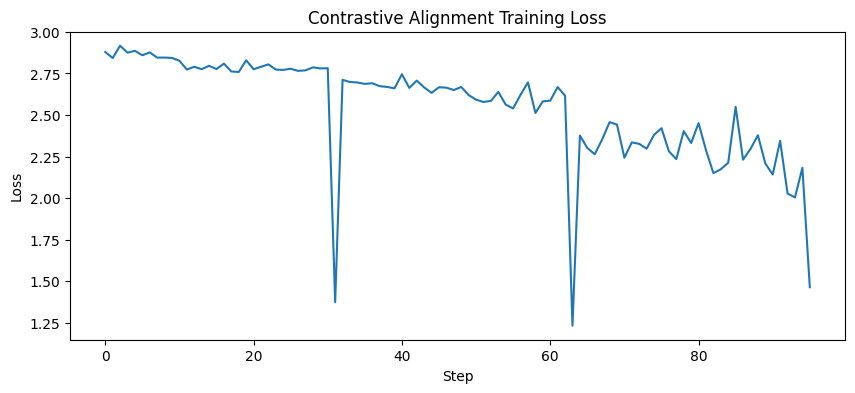

In [55]:
# Plot alignment loss
plt.figure(figsize=(10, 4))
plt.plot(alignment_loss_history)
plt.title('Contrastive Alignment Training Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.show()

## 3.6 Visualize Learned Embeddings

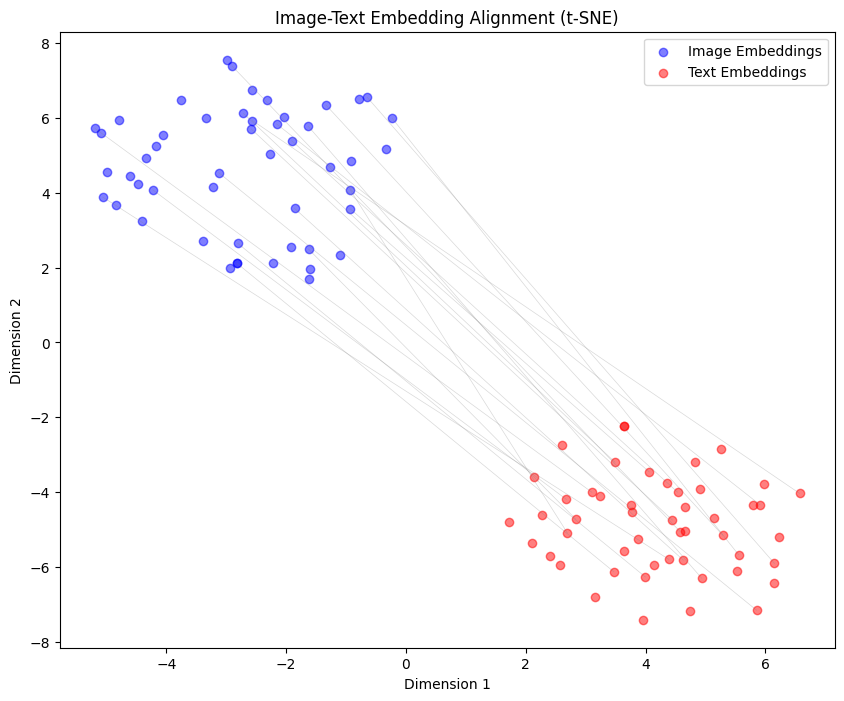

In [56]:
from sklearn.manifold import TSNE

def visualize_embeddings(model, dataloader, device='cuda', num_samples=100):
    """
    Visualize image and text embeddings in shared space using t-SNE.
    """
    model.eval()
    
    image_embeds_list = []
    text_embeds_list = []
    
    with torch.no_grad():
        samples_collected = 0
        for images, captions in dataloader:
            if samples_collected >= num_samples:
                break
            
            images = images.to(device)
            captions = captions.to(device)
            
            # Get embeddings
            img_emb = model.encode_image(images)
            txt_emb = model.encode_text(captions)
            
            # Project to shared space
            img_proj = model.vision_proj(img_emb)
            txt_proj = model.text_proj(txt_emb)
            
            image_embeds_list.append(img_proj.cpu())
            text_embeds_list.append(txt_proj.cpu())
            
            samples_collected += images.shape[0]
    
    # Concatenate
    image_embeds = torch.cat(image_embeds_list, dim=0)[:num_samples].numpy()
    text_embeds = torch.cat(text_embeds_list, dim=0)[:num_samples].numpy()
    
    # Combine for t-SNE
    all_embeds = np.concatenate([image_embeds, text_embeds], axis=0)
    
    # t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, num_samples-1))
    embeds_2d = tsne.fit_transform(all_embeds)
    
    # Plot
    plt.figure(figsize=(10, 8))
    
    # Image embeddings
    plt.scatter(
        embeds_2d[:num_samples, 0], 
        embeds_2d[:num_samples, 1],
        c='blue', alpha=0.5, label='Image Embeddings'
    )
    
    # Text embeddings
    plt.scatter(
        embeds_2d[num_samples:, 0], 
        embeds_2d[num_samples:, 1],
        c='red', alpha=0.5, label='Text Embeddings'
    )
    
    # Draw lines connecting matched pairs
    for i in range(min(20, num_samples)):  # Show first 20 pairs
        plt.plot(
            [embeds_2d[i, 0], embeds_2d[num_samples + i, 0]],
            [embeds_2d[i, 1], embeds_2d[num_samples + i, 1]],
            'gray', alpha=0.3, linewidth=0.5
        )
    
    plt.legend()
    plt.title('Image-Text Embedding Alignment (t-SNE)')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.show()

# Visualize embeddings
visualize_embeddings(vlm_model, alignment_dataloader, device=device, num_samples=50)

---
# Summary and Next Steps

## What We Implemented:

### Part 1: TRM Decoder LLM
- Decoder-only transformer with TRM-style recursive reasoning
- Deep supervision across multiple recursion cycles
- Causal self-attention with RoPE
- SwiGLU activation and RMSNorm

### Part 2: Training and Evaluation
- Character-level language modeling
- Analysis of how predictions evolve across recursion steps
- Text generation with sampling strategies

### Part 3: TRM VLM
- Vision encoder with TRM recursive reasoning
- CLIP-style contrastive alignment
- Image-conditioned text generation (basic)

## Key Insights from TRM:
1. **Less is More**: 2-layer networks with many recursions outperform deeper networks
2. **Deep Supervision**: Computing loss at each recursion step improves training
3. **Single Network**: One shared network for both z and y updates works better
4. **Recursive Refinement**: Model progressively improves its answer

## Next Steps for Production:
1. Scale up vocabulary and model size
2. Train on real datasets (e.g., WikiText, C4)
3. For VLM: Use real image-caption datasets (COCO, CC3M)
4. Implement proper cross-attention for image conditioning
5. Add more sophisticated sampling strategies
6. Implement KV-cache for efficient generation
7. Add gradient checkpointing for memory efficiency

In [57]:
# Final summary
print("=" * 70)
print("TRM Decoder LLM & VLM Implementation Summary")
print("=" * 70)
print(f"\nLLM Configuration:")
print(f"  - Hidden Size: {train_config.hidden_size}")
print(f"  - Layers: {train_config.num_layers}")
print(f"  - Recursions (n): {train_config.n_recursions}")
print(f"  - Cycles (T): {train_config.t_cycles}")
print(f"  - Parameters: {count_parameters(trm_model):,}")

print(f"\nVLM Configuration:")
print(f"  - Vision Embed Dim: {vlm_config.vision_embed_dim}")
print(f"  - Language Hidden Size: {vlm_config.lang_hidden_size}")
print(f"  - Total Parameters: {count_parameters(vlm_model):,}")

print("\n" + "=" * 70)
print("Implementation Complete!")
print("=" * 70)

TRM Decoder LLM & VLM Implementation Summary

LLM Configuration:
  - Hidden Size: 128
  - Layers: 2
  - Recursions (n): 4
  - Cycles (T): 3
  - Parameters: 403,072

VLM Configuration:
  - Vision Embed Dim: 128
  - Language Hidden Size: 128
  - Total Parameters: 1,359,617

Implementation Complete!


In [73]:
import torch
from pathlib import Path

save_dir = Path("artifacts/trm_vlm_model")  # change if you prefer another folder
save_dir.mkdir(parents=True, exist_ok=True)

ckpt_path = save_dir / "pytorch_model.bin"
config_path = save_dir / "config.pt"


In [74]:

# Save weights and config from the current model
import dataclasses
torch.save(vlm_model.state_dict(), ckpt_path)
torch.save(dataclasses.asdict(vlm_config), config_path)  # save dict to avoid notebook pickling issues
print(f"Saved weights to {ckpt_path}")
print(f"Saved config to {config_path}")

# Optional: save tokenizer if you used one
# tokenizer.save_pretrained(save_dir)


Saved weights to artifacts/trm_vlm_model/pytorch_model.bin
Saved config to artifacts/trm_vlm_model/config.pt


In [75]:
# 2) Save config to reload later
import dataclasses
torch.save(dataclasses.asdict(vlm_config), config_path)  # store as plain dict for reliable reloads
print(f"Saved config to {config_path}")

Saved config to artifacts/trm_vlm_model/config.pt
